# subplot

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.ndimage as ndi
import torch.nn.functional as F
import torch

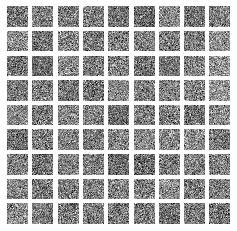

In [2]:
image_grid_rows = 9
image_grid_columns = 9
gen_imgs = np.random.normal(0, 1, (image_grid_rows**2, 28, 28)).astype(np.float32)
# Set image grid
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(4, 4),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output a grid of images
        axs[i, j].imshow(gen_imgs[cnt, :, :], cmap='gray')
        axs[i, j].axis('off')
        cnt += 1


# heatmap visulization
    COLORMAP_AUTUMN = 0,
    COLORMAP_BONE = 1,
    COLORMAP_JET = 2,
    COLORMAP_WINTER = 3,
    COLORMAP_RAINBOW = 4,
    COLORMAP_OCEAN = 5,
    COLORMAP_SUMMER = 6,
    COLORMAP_SPRING = 7,
    COLORMAP_COOL = 8,
    COLORMAP_HSV = 9,
    COLORMAP_PINK = 10,
    COLORMAP_HOT = 11
## generate heatmap

In [5]:
# gaussian type
def generate_heatmap(background, pt, sigma, label_type='Gaussian'):
    # check that any part of the gassian is in-bounds
    tmp_size = sigma * 3
    # pt = [x,y]
    upper_left = [int(pt[0] - tmp_size), int(pt[1] - tmp_size)]
    bottom_right = [int(pt[0] + tmp_size + 1), int(pt[1] + tmp_size + 1)]
    if (upper_left[0] >= background.shape[1] or upper_left[1] >= background.shape[0] or bottom_right[0] < 0 or bottom_right[1] < 0):
        return img
    """
    generate gaussian heatmap
        先生成小的heatmap，再将heatmap贴合到背景上
    """
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    # the gaussian is not normalized, we want the center value to equal to 1
    if label_type == 'Gaussian':
        g = np.exp(-((x-x0)**2 + (y-y0)**2) / (2 *sigma **2))
    else:
        pass
    # Usable gaussian range
    g_x = max(0, -upper_left[0]), min(bottom_right[0], background.shape[1]) - upper_left[0]
    g_y = max(0, -upper_left[1]), min(bottom_right[1], background.shape[0]) - upper_left[1]
    # Image range
    img_x = max(0, upper_left[0]), min(bottom_right[0], background.shape[1])
    img_y = max(0, upper_left[1]), min(bottom_right[1], background.shape[0])

    img[img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
    return img

def random_shift(img, max_pixel, ori_peak_coords):
    """
    shift the heatmap
    img = (h, w), ndarray
    lr:  >0 right; <0 left [-mp, mp]
    ud:  >0 up;    <0 down [-mp, mp]
    """
    if len(img.shape) == 3:
        img = np.squeeze(img)
    lr = np.random.randint(-max_pixel, max_pixel) # 5
    ud = np.random.randint(-max_pixel, max_pixel) # 6
    # lr=20
    # ud=20
    print(lr, ud)
    h, w = img.shape[:2]
    padding_img = np.zeros((h+np.abs(2*ud), w+np.abs(2*lr)))
    padding_img[np.abs(ud):np.abs(ud)+64,np.abs(lr):np.abs(lr)+64] = img
    if ud>=0 and lr>=0:
        shift = padding_img[:h,:w]
        peak_coords = [ori_peak_coords[0] + lr, ori_peak_coords[1] + ud]
    elif ud>=0 and lr<0:
        shift = padding_img[:-h,:w]
        peak_coords = [ori_peak_coords[0] - lr, ori_peak_coords[1] + ud]
    elif ud<0 and lr<0:
        shift = padding_img[:-h,:-w]
        peak_coords = [ori_peak_coords[0] - lr, ori_peak_coords[1] - ud]
    else: # ud <0 lr >0
        shift = padding_img[:h,:-w]
        peak_coords = [ori_peak_coords[0] + lr, ori_peak_coords[1] - ud]
    
    return padding_img[:h,:w], np.array(peak_coords)

## heatmap vis


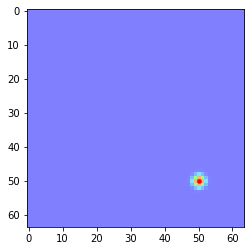

(49,)
[1.23409802e-04 1.50343915e-03 6.73794700e-03 1.11089963e-02
 6.73794700e-03 1.50343915e-03 1.23409802e-04 1.50343915e-03
 1.83156393e-02 8.20849985e-02 1.35335281e-01 8.20849985e-02
 1.83156393e-02 1.50343915e-03 6.73794700e-03 8.20849985e-02
 3.67879450e-01 6.06530666e-01 3.67879450e-01 8.20849985e-02
 6.73794700e-03 1.11089963e-02 1.35335281e-01 6.06530666e-01
 1.00000000e+00 6.06530666e-01 1.35335281e-01 1.11089963e-02
 6.73794700e-03 8.20849985e-02 3.67879450e-01 6.06530666e-01
 3.67879450e-01 8.20849985e-02 6.73794700e-03 1.50343915e-03
 1.83156393e-02 8.20849985e-02 1.35335281e-01 8.20849985e-02
 1.83156393e-02 1.50343915e-03 1.23409802e-04 1.50343915e-03
 6.73794700e-03 1.11089963e-02 6.73794700e-03 1.50343915e-03
 1.23409802e-04]


In [96]:
# 2. show input and target
def data_visulization(score_map, pt):
    """
    score map must shape like (N, H, W) and its type should be ndarray.
    pt must shape like (N, 2) and its type should be ndarray.
    N: num of heatmap
    """
#     if instance(pt):
#     print(instance(pt))
    if len(score_map.shape) == 4:
        score_map = np.squeeze(score_map)
    elif len(score_map.shape) == 2:
        score_map = np.expand_dims(score_map, axis=0)
        
    if len(pt.shape) == 1:
        pt = np.expand_dims(pt, axis=0)
#     print(pt.shape)
    for i in range(0, score_map.shape[0]):
        m = score_map[i,:,:]
        m = np.uint8(m*255.)
        colormap = cv2.applyColorMap(m, cv2.COLORMAP_HSV)
#         plt.axis('off')
#         plt.imshow(img)
        plt.imshow(colormap, alpha=0.5)
        plt.plot(pt[i,0], pt[i,1], 'r.', ms=7)
#         plt.savefig('../../Heatmap-finetune-speed-up-network/heatmaps/pred_colormap_' + str(i) + '.jpg')
        plt.show()
        
img = np.zeros((64,64))
pt = np.array([50,50]) # x,y
sigma = 1
img = generate_heatmap(img, pt, sigma) 
data_visulization(img, pt)
# img = (generate_target(img, pt, sigma)*255.).astype(np.uint8)
# img = ndi.grey_dilation(img, size=(3,3))
# img, peak_coords = random_shift(img, 20, pt)
# data_visulization(img, peak_coords)
# print("peak_coords is {0}, and its value is {1}.".format(peak_coords, img[peak_coords[0], peak_coords[1]]))

print(img[img>0].shape)
print(img[img>0])

In [97]:
y = np.arange(0, 64, 1, np.float32)+1
# x = x[:, np.newaxis]
y = np.repeat(y, 64).reshape(64,64)
x = np.transpose(y)
print(x,'\n\n', y)

tensor = torch.from_numpy(img*x).unsqueeze(dim=0)
x_ = np.sum(x*img) / 13.67515577887931 #/ 64
y_ = np.sum(y*img) / 13.67515577887931 #/ 64 
print(x_,y_)
x = np.mean(x*img) #/ 64 0.007665752992878083 0.016864656584331783
y = np.mean(y*img) #/ 64 
_ = F.adaptive_avg_pool2d(tensor, (1,1))
print(x, _)
print(x,y)

[[ 1.  2.  3. ... 62. 63. 64.]
 [ 1.  2.  3. ... 62. 63. 64.]
 [ 1.  2.  3. ... 62. 63. 64.]
 ...
 [ 1.  2.  3. ... 62. 63. 64.]
 [ 1.  2.  3. ... 62. 63. 64.]
 [ 1.  2.  3. ... 62. 63. 64.]] 

 [[ 1.  1.  1. ...  1.  1.  1.]
 [ 2.  2.  2. ...  2.  2.  2.]
 [ 3.  3.  3. ...  3.  3.  3.]
 ...
 [62. 62. 62. ... 62. 62. 62.]
 [63. 63. 63. ... 63. 63. 63.]
 [64. 64. 64. ... 64. 64. 64.]]
23.41977178312614 23.41977178312614
0.07819068052735645 tensor([[[0.0782]]], dtype=torch.float64)
0.07819068052735645 0.07819068052735645


# DNST Module

In [92]:
y = np.arange(-0.8, 1.2, 0.4, np.float16)
y = np.repeat(y, 5).reshape(5,5)
x = y.transpose()
print(x,'\n\n', y)

h = np.array([[0,0,0,0,0],
              [0,0,0.1,0,0],
              [0,0.1,0.6,0.1,0],
              [0,0,0.1,0,0],
              [0,0,0,0,0]])

h = np.array([[0,0,0,0,0],
              [0,0,0,0.1,0],
              [0,0,0.1,0.6,0.1],
              [0,0,0,0.1,0],
              [0,0,0,0,0]])

# h = np.array([[0,0,0,0.1,0],
#               [0,0,0.1,0.6,0.1],
#               [0,0,0,0.1,0],
#               [0,0,0,0,0],
#               [0,0,0,0,0]])


x = np.sum(h*x)
y = np.sum(h*y)


print(x,y)

[[-0.8 -0.4  0.   0.4  0.8]
 [-0.8 -0.4  0.   0.4  0.8]
 [-0.8 -0.4  0.   0.4  0.8]
 [-0.8 -0.4  0.   0.4  0.8]
 [-0.8 -0.4  0.   0.4  0.8]] 

 [[-0.8 -0.8 -0.8 -0.8 -0.8]
 [-0.4 -0.4 -0.4 -0.4 -0.4]
 [ 0.   0.   0.   0.   0. ]
 [ 0.4  0.4  0.4  0.4  0.4]
 [ 0.8  0.8  0.8  0.8  0.8]]
0.39990234375 tensor([[[0.0160]]], dtype=torch.float64)
0.39990234375 0.0
